In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import torch.nn as nn
import blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing = training_set.isnull().any()
print(any_missing)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)






V2    False
dtype: bool
all training set length:  48000


In [2]:
train_set=training_set[:42500]
print(train_set.shape)

(42500, 1)


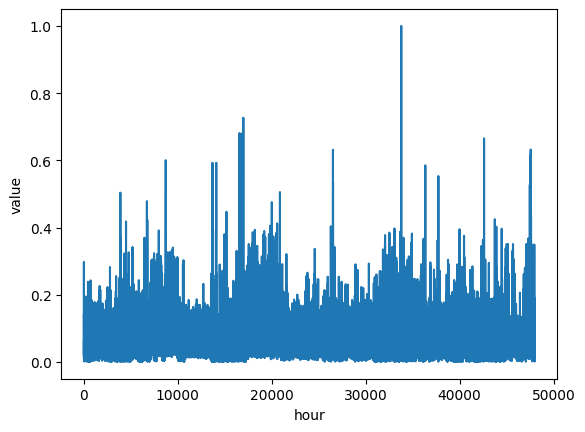

In [3]:
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(training_set)
plt.show()

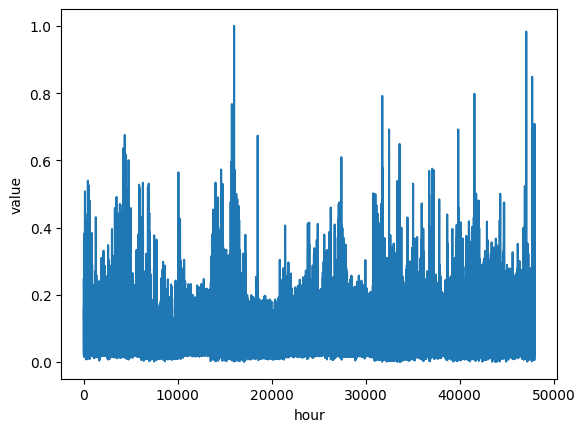

In [4]:
test_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

test_set = test_set.iloc[:,1:2].values
sc = MinMaxScaler()
test_set = sc.fit_transform(test_set)
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(test_set)
plt.show()

In [5]:

seq_length = 512 #it is tau in the paper
x, y = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x))
print(trainX.shape)


torch.Size([41987, 512, 1])


In [6]:
sequences=utils.real_seq(training_set,seq_length)
sequences=sequences[:41987]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)

float64
torch.Size([41987, 1, 512])


# *TRAIN*

In [7]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

In [8]:

path="Models/M4"
utils.create_folder(path)


The new models directory is created!


In [9]:
%%time

embedding_dim=10
batch_size=trainX.size(0)
value_features=1
key_features=1

#extract the number of features
num_features=trainX.size(2)+10

#Hyperparameters
discriminator_lr=0.0005
generator_lr=0.0005
num_epochs=1
batch_size=121
criterion = nn.MSELoss()

#Initializations
train = TensorDataset(trainX, sequences)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False) 


D = blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
G=blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features)
optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))


#Training
g_losses = []
d_losses = []
save=False
for epoch in range(num_epochs):
        g_loss_min=1000000
        d_loss_min=1000000
        g_losses_temp=[]
        d_losses_temp=[]
        for i, (X, Y) in enumerate((train_loader)):
            #print("i:",i)
            #print("X in (train_loader):",X.shape)
            #print("Y:",Y.shape)
            
              
            # Generate fake data
            fake_data = G(X)
            fake_label = torch.zeros(Y.size(0))
            
            # Train the discriminator
            D.zero_grad()
            d_real_loss = criterion(D(Y,X), torch.ones_like(D(Y,X)))
            d_fake_loss = criterion(D(fake_data.detach(),X), torch.zeros_like(D(fake_data.detach(),X)))
            d_loss = d_real_loss + d_fake_loss
            d_losses_temp.append(d_loss.item())
            d_loss.backward(retain_graph=False)
            optimD.step()
            
            # Train the generator
            G.zero_grad()
            g_loss = criterion(D(fake_data,X), torch.ones_like(D(fake_data,X)))

            # Add the moment loss
            g_loss += moment_loss(fake_data, Y)
            #g_loss = moment_loss(fake_data, Y)
            g_losses_temp.append(g_loss.item())

            if(g_loss<g_loss_min and d_loss<d_loss_min and save):
                g_loss_min = g_loss
                d_loss_min = d_loss
                torch.save(G.state_dict(), path+'/generator.pt')
                torch.save(G, path+'/generator_model.pt')
                torch.save(D.state_dict(), path+'/discriminator.pt')
                torch.save(D, path+'/discriminator_model.pt')
                print('Improvement-Detected, model saved')

            g_loss.backward()
            optimG.step()
            
            # Print the losses
            if (i+1) % 1 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % 
                    (epoch+1, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))
        g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
        d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))

[Epoch 1/1] [Batch 1/347] [D loss: 1.858357] [G loss: 8.251886]
[Epoch 1/1] [Batch 2/347] [D loss: 1.857018] [G loss: 8.363770]
[Epoch 1/1] [Batch 3/347] [D loss: 1.854594] [G loss: 8.071445]
[Epoch 1/1] [Batch 4/347] [D loss: 1.852377] [G loss: 7.907344]
[Epoch 1/1] [Batch 5/347] [D loss: 1.850452] [G loss: 8.238705]
[Epoch 1/1] [Batch 6/347] [D loss: 1.848808] [G loss: 8.622303]
[Epoch 1/1] [Batch 7/347] [D loss: 1.847167] [G loss: 8.899981]
[Epoch 1/1] [Batch 8/347] [D loss: 1.845527] [G loss: 9.171968]
[Epoch 1/1] [Batch 9/347] [D loss: 1.843890] [G loss: 8.668799]
[Epoch 1/1] [Batch 10/347] [D loss: 1.842254] [G loss: 8.362868]
[Epoch 1/1] [Batch 11/347] [D loss: 1.840619] [G loss: 7.542697]
[Epoch 1/1] [Batch 12/347] [D loss: 1.838985] [G loss: 7.262224]
[Epoch 1/1] [Batch 13/347] [D loss: 1.837353] [G loss: 7.211519]
[Epoch 1/1] [Batch 14/347] [D loss: 1.835722] [G loss: 7.249519]
[Epoch 1/1] [Batch 15/347] [D loss: 1.834092] [G loss: 7.772142]
[Epoch 1/1] [Batch 16/347] [D loss

End-training Generator Loss: tensor(3.1586)
End-training Discriminator Loss: tensor(1.2545)


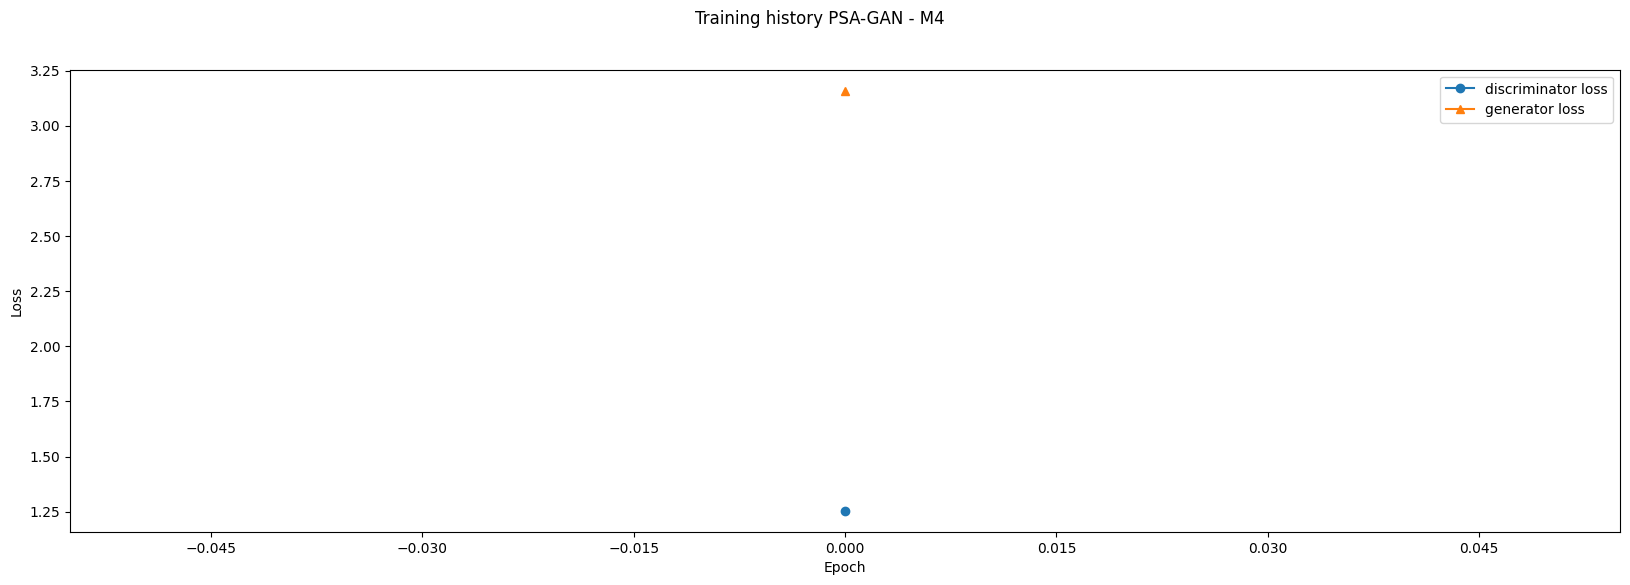

In [10]:

utils.plot_training_history('PSA-GAN - M4',d_losses, g_losses)


In [12]:
with torch.no_grad():
    
    generated_series = G(trainX[:batch_size]) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.detach().numpy()
    #print("generated_series: ",generated_series.shape)


generated_series:  torch.Size([121, 512, 1])


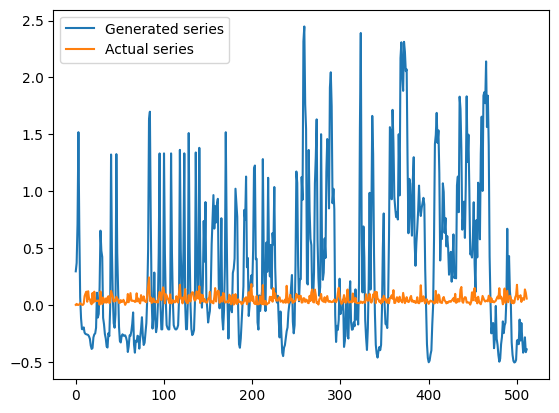

Gamma Self-Attention: Parameter containing:
tensor([-0.0021], requires_grad=True)


In [14]:
# Plot the generated time series samples

plt.figure()
#for i in range(trainX.size(0)):
#    plt.plot(generated_series[i], label='Generated series')
#plt.plot(utils.scale(generated_series[batch_size-1]), label='Generated scaled series')
plt.plot((generated_series[batch_size-1]), label='Generated series')
plt.plot(training_set[batch_size+seq_length-1:batch_size+2*seq_length-1], label='Actual series')
#sequences=sequences.permute(0,2,1)
#plt.plot(sequences[batch_size-1],label="label series")
plt.legend()
plt.show()

#print("Context FID:",fid_score)
print("Gamma Self-Attention:",G.main.attn.gamma)

In [15]:
with torch.no_grad():
    
    generated_series = G(trainX[:batch_size]) #substitue trainX with testX
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.detach().numpy()
    #print("generated_series: ",generated_series.shape)

generated_series:  torch.Size([121, 512, 1])


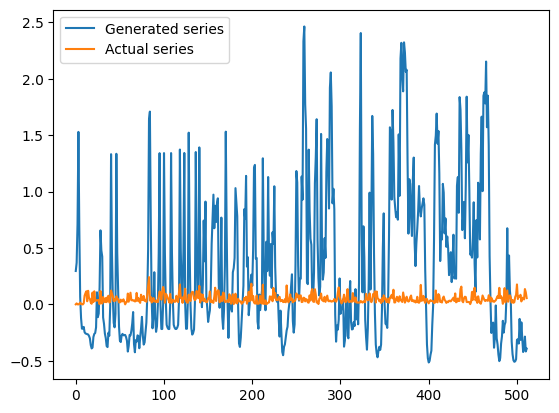

Gamma of Self-Attention: Parameter containing:
tensor([-0.0021], requires_grad=True)


In [19]:
# Plot the generated time series samples

plt.figure()
#for i in range(trainX.size(0)):
#    plt.plot(generated_series[i], label='Generated series')
#plt.plot(utils.scale(generated_series[batch_size-1]), label='Generated scaled series')
plt.plot((generated_series[batch_size-1]), label='Generated series')
plt.plot(training_set[batch_size+seq_length-1:batch_size+2*seq_length-1], label='Actual series')
#sequences=sequences.permute(0,2,1)
#plt.plot(sequences[batch_size-1],label="label series")
plt.legend()
plt.show()

#print("Context FID:",fid_score)
print("Gamma of Self-Attention:",G.main.attn.gamma)